In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import timeit
from src.mlmodel import *
import pickle
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
import src.utils as utils
from torchvision import transforms
import torchvision.models as models
from torch import nn

In [2]:
model_pre = models.resnet101(pretrained=True)
print(list(model_pre.children())[0])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [3]:
class res101_featureExtract(nn.Module):
    def __init__(self, model):
        super(res101_featureExtract, self).__init__() 
        self.features = nn.Sequential(*list(model.children())[:-1])       
    def forward(self, x):
        x = self.features(x)       
        return x
feature_model = res101_featureExtract(model_pre)
#print(list(feature_model.children())[0])

In [4]:
# !ls
# !ls ./CUB_200_2011/images/001.Black_footed_Albatross/

In [5]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
path = '../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg'
image = cv2.imread(path)
image = Image.open(path)

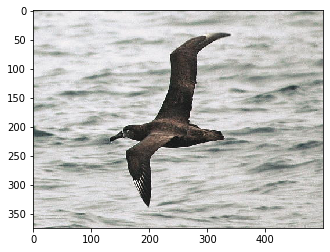

In [6]:
plt.imshow(image)
plt.show()

In [7]:
trans = transforms.ToTensor()
ii = torch.unsqueeze(trans(image),0)
print(ii.shape)
featrue = feature_model(ii)
print(featrue.size())

torch.Size([1, 3, 375, 500])
torch.Size([1, 2048, 1, 1])


In [8]:
path_indx_name = '../ZSTL_Data/CUB_200_2011/CUB_200_2011/images.txt'
path_indx_class = '../ZSTL_Data/CUB_200_2011/CUB_200_2011/image_class_labels.txt'

data_indx_name = pd.read_csv(path_indx_name, sep=" ", header=None)
print(data_indx_name)
data_indx_class = pd.read_csv(path_indx_class, sep=" ", header=None)
print(data_indx_class)

data = pd.concat([data_indx_name, data_indx_class], axis=1)
#df.rename(columns={'0': 'a'})
print(data)

0                                                  1
0          1  001.Black_footed_Albatross/Black_Footed_Albatr...
1          2  001.Black_footed_Albatross/Black_Footed_Albatr...
2          3  001.Black_footed_Albatross/Black_Footed_Albatr...
3          4  001.Black_footed_Albatross/Black_Footed_Albatr...
4          5  001.Black_footed_Albatross/Black_Footed_Albatr...
...      ...                                                ...
11783  11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784  11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785  11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786  11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787  11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
           0    1
0          1    1
1          2    1
2          3    1
3          4    1
4          5    1
...      ...  ...
11783  11784  200
11784  11785  200
11785  11786  200
11786  11787  200
11787  11788  200



In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model_ft = model_ft.to(device)

cpu


In [10]:
#inception_v3
# model_pre = models.inception_v3(pretrained=True)
# print(list(model_pre.children())[0])

In [11]:
def genFeature(data, path_prefix, feature_model, device):
    feature_lst = []
    label_lst = []
    dim = 2048
    trans = transforms.ToTensor()
    i = 0
    less_channel = []
    feature_model = feature_model.to(device)
    for cur_data in data.iterrows():
        i+=1
        # if i >10:
        #     break
        # print('cur_data ', cur_data)
        #print(cur_data[1], cur_data[1].to_numpy())
        cur_data_np = cur_data[1].to_numpy()
        img_path = path_prefix + cur_data_np[1]
        print(img_path)
        try:
          image = Image.open(img_path)
        except FileNotFoundError as error:
          print('error occur ', error)
          continue
        

        ii = torch.unsqueeze(trans(image), 0)
        ii = ii.to(device)
        try:
          featrue = torch.squeeze(feature_model(ii))
        except RuntimeError as error:
          print('error occur ', error)
          less_channel.append(img_path)
          continue
        #print(featrue.size())
        # plt.imshow(image)
        # plt.show()

        feature_lst.append(np.expand_dims(utils.toNumpy(featrue.cpu()), 0))
        # temp = np.expand_dims(utils.toNumpy(featrue), 0)
        # print(temp.shape)
        label_lst.append(cur_data_np[-1])
    
    label_lst = np.expand_dims(np.array(label_lst), axis=0)
    print('label_lst ', label_lst.shape)
    feature_lst = np.concatenate(feature_lst, axis=0)
    print(feature_lst.shape)
    data_label_feature_np = np.hstack((label_lst.T, feature_lst))
    data_label_feature =  pd.DataFrame(data_label_feature_np,
                   columns=['label'] +[i for i in range(dim)])
    print(data_label_feature)
    print('tot count ', i)
    return data_label_feature, less_channel
    
        

path_prefix = '../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/'
data_label_feature, image_path = genFeature(data, path_prefix, feature_model, device)


../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg
../ZSTL_Data/CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
../ZSTL_Data/CUB_20

KeyboardInterrupt: 

In [ ]:
print(data_label_feature)
print(image_path)

In [ ]:
data_label_feature.to_csv(r'./pandas.txt', header=None, index=None, sep=' ', mode='w')